In [3]:
%matplotlib inline

import os
from scipy import ndimage as ndi
from skimage import io, filters, exposure, color, img_as_float
import matplotlib.pylab as plt
import matplotlib
import numpy as np
from ipywidgets import interact, widgets, HBox
from IPython import display
import math
from random import randint

#Ajustar el tamaño de las imágenes:
matplotlib.rcParams['figure.figsize'] = (14,12)

In [9]:
# image = exposure.rescale_intensity(img_as_float(io.imread(imageFile)))

def gaborFilter(x, y, orientation, bandwidth, deviationX, deviationY):
    orientationX = x*math.cos(orientation) - y*math.sin(orientation)
    orientationY = x*math.sin(orientation) - y*math.cos(orientation)
    
    firstTermX = orientationX * orientationX / deviationX
    firstTermY = orientationY * orientationY / deviationY
    firstTerm = math.exp ( -1/2 * (firstTermX + firstTermY) )
    secondTerm = math.cos(2 * math.pi * (1/bandwidth) * orientationX )
    
    return firstTerm * secondTerm;

gaborFilter(1, 3, math.pi / 4, 20, 10, 10)

0.7392457486079784

In [16]:
#x,y: es una coordenada en el filtro. Si definimos un filtro con radios rx, ry,
#entonces x ∈ [−rx,rx] e y ∈ [−ry,ry]. Recuerde, además, que el tamaño
#de un filtro gaussiano depende de su desviación estándar correspondiente.

def gabor_fn(theta, Lambda, sigma_x, sigma_y):

    # Bounding box
    nstds = 3 # Number of standard deviation sigma
    xmax = max(abs(nstds * sigma_x * np.cos(theta)), abs(nstds * sigma_y * np.sin(theta)))
    xmax = np.ceil(max(1, xmax))
    ymax = max(abs(nstds * sigma_x * np.sin(theta)), abs(nstds * sigma_y * np.cos(theta)))
    ymax = np.ceil(max(1, ymax))
    xmin = -xmax
    ymin = -ymax
    (y, x) = np.meshgrid(np.arange(ymin, ymax + 1), np.arange(xmin, xmax + 1))

    # Rotation 
    x_theta = x * np.cos(theta) + y * np.sin(theta)
    y_theta = -x * np.sin(theta) + y * np.cos(theta)

    gb = np.exp(-.5 * (x_theta ** 2 / sigma_x ** 2 + y_theta ** 2 / sigma_y ** 2)) * np.cos(2 * np.pi / Lambda * x_theta)
    return gb

In [20]:
gabor_fn(math.pi/4, 10, 1, 1)

array([[ -1.09698698e-04,  -9.10632919e-04,  -1.38057441e-03,
          2.61831109e-03,   4.24839338e-03,   1.35748050e-03,
          1.23409804e-04],
       [ -9.10632919e-04,  -3.75279033e-03,   1.93468476e-02,
          8.53312620e-02,   7.41159240e-02,   1.83156389e-02,
          1.35748050e-03],
       [ -1.38057441e-03,   1.93468476e-02,   2.31954419e-01,
          5.47646720e-01,   3.67879441e-01,   7.41159240e-02,
          4.24839338e-03],
       [  2.61831109e-03,   8.53312620e-02,   5.47646720e-01,
          1.00000000e+00,   5.47646720e-01,   8.53312620e-02,
          2.61831109e-03],
       [  4.24839338e-03,   7.41159240e-02,   3.67879441e-01,
          5.47646720e-01,   2.31954419e-01,   1.93468476e-02,
         -1.38057441e-03],
       [  1.35748050e-03,   1.83156389e-02,   7.41159240e-02,
          8.53312620e-02,   1.93468476e-02,  -3.75279033e-03,
         -9.10632919e-04],
       [  1.23409804e-04,   1.35748050e-03,   4.24839338e-03,
          2.61831109e-03,  -1.38

In [22]:

def orientations(image, numCells):
    Gx = filters.sobel_h(image)
    Gy = filters.sobel_v(image)
    mag = math.sqrt(Gx^*Gx + Gy*Gy)
    angles = math.atan2(Gy, Gx)
    m_sines = np.zeros((numCells, numCells))
    m_cosines = np.zeros((numCells, numCells))
    m, n = image.shape()
    for i in range(m):
        for j in range(n):
            alpha = angles(i,j)
            #m_sines = 

SyntaxError: invalid syntax (<ipython-input-22-763b815fc8b0>, line 4)

In [29]:
W = 4
for i in range(W*W):
    print(math.floor(i/W))

0
0
0
0
1
1
1
1
2
2
2
2
3
3
3
3


In [31]:
def createCellDemo(imageSize, cellSize):
    cellImage = np.zeros((imageSize, imageSize))
    cellCount = math.floor(imageSize/cellSize)
    cellPixels = np.zeros((cellSize, cellSize, cellCount))
    print(cellCount)
    
createCellDemo(64,4) 

16


In [76]:
def createCellDemo(imageSize, cellSize):
    cellImage = np.zeros((imageSize, imageSize))
    cellCount = math.floor(imageSize/cellSize)
    cellPixels = np.zeros((cellCount, cellCount)) 
    for j in range(imageSize):
        for i in range(imageSize):
            cellX = math.floor(i/cellSize)
            cellY = math.floor(j/cellSize)
            cellIndex = cellY * cellCount + cellX
            print("i:",i,"j:", j,"cellX:", cellX,"cellY:", cellY,"index:", cellIndex)
    
createCellDemo(16,4)

i: 0 j: 0 cellX: 0 cellY: 0 index: 0
i: 1 j: 0 cellX: 0 cellY: 0 index: 0
i: 2 j: 0 cellX: 0 cellY: 0 index: 0
i: 3 j: 0 cellX: 0 cellY: 0 index: 0
i: 4 j: 0 cellX: 1 cellY: 0 index: 1
i: 5 j: 0 cellX: 1 cellY: 0 index: 1
i: 6 j: 0 cellX: 1 cellY: 0 index: 1
i: 7 j: 0 cellX: 1 cellY: 0 index: 1
i: 8 j: 0 cellX: 2 cellY: 0 index: 2
i: 9 j: 0 cellX: 2 cellY: 0 index: 2
i: 10 j: 0 cellX: 2 cellY: 0 index: 2
i: 11 j: 0 cellX: 2 cellY: 0 index: 2
i: 12 j: 0 cellX: 3 cellY: 0 index: 3
i: 13 j: 0 cellX: 3 cellY: 0 index: 3
i: 14 j: 0 cellX: 3 cellY: 0 index: 3
i: 15 j: 0 cellX: 3 cellY: 0 index: 3
i: 0 j: 1 cellX: 0 cellY: 0 index: 0
i: 1 j: 1 cellX: 0 cellY: 0 index: 0
i: 2 j: 1 cellX: 0 cellY: 0 index: 0
i: 3 j: 1 cellX: 0 cellY: 0 index: 0
i: 4 j: 1 cellX: 1 cellY: 0 index: 1
i: 5 j: 1 cellX: 1 cellY: 0 index: 1
i: 6 j: 1 cellX: 1 cellY: 0 index: 1
i: 7 j: 1 cellX: 1 cellY: 0 index: 1
i: 8 j: 1 cellX: 2 cellY: 0 index: 2
i: 9 j: 1 cellX: 2 cellY: 0 index: 2
i: 10 j: 1 cellX: 2 cellY: 0 ind

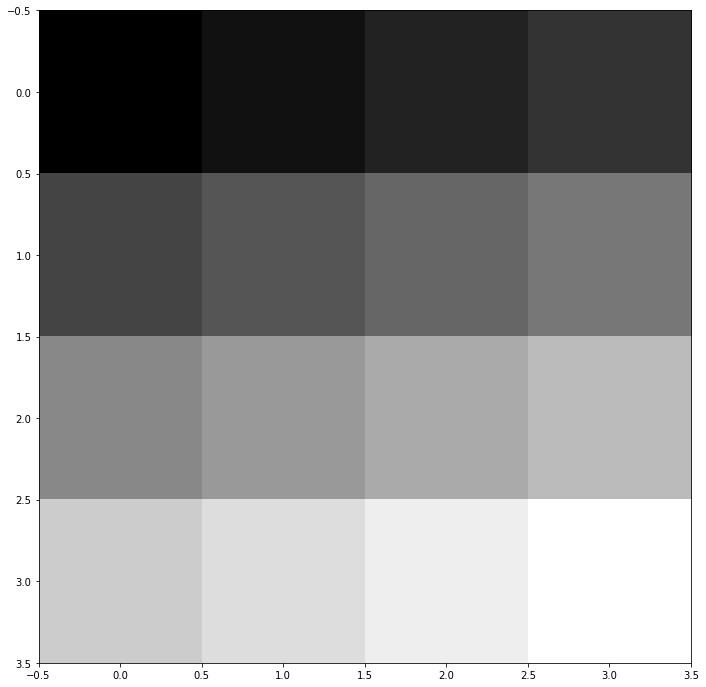

In [83]:
def createCellDemo(imageSize, cellSize):
    cellImage = np.zeros((imageSize, imageSize))
    cellCount = math.floor(imageSize/cellSize)
    cellPixels = np.zeros((cellCount, cellCount)) 
    for j in range(imageSize):
        for i in range(imageSize):
            cellX = math.floor(i/cellSize)
            cellY = math.floor(j/cellSize)
            cellIndex = cellX * cellCount + cellY
            
            cellPixels[cellX, cellY] = cellIndex
    
    
    plt.imshow(cellPixels, cmap="gray")
        
createCellDemo(16,4)

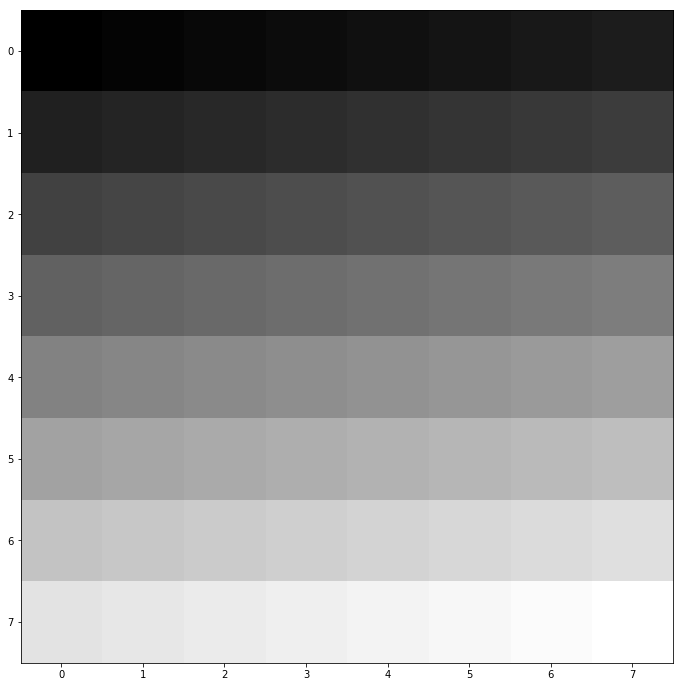

In [84]:
createCellDemo(32,4)

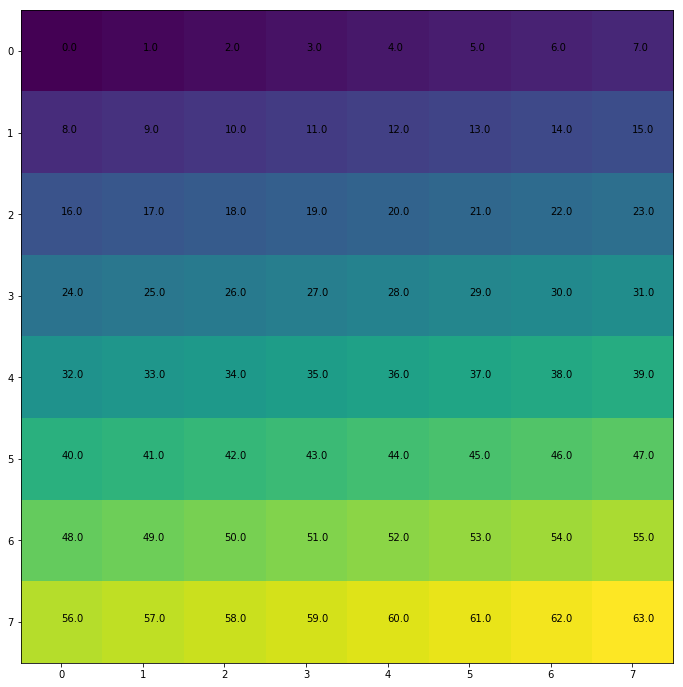

In [87]:
def createCellDemo(imageSize, cellSize):
    cellImage = np.zeros((imageSize, imageSize))
    cellCount = math.floor(imageSize/cellSize)
    cellPixels = np.zeros((cellCount, cellCount)) 
    for j in range(imageSize):
        for i in range(imageSize):
            cellX = math.floor(i/cellSize)
            cellY = math.floor(j/cellSize)
            cellIndex = cellX * cellCount + cellY
            
            cellPixels[cellX, cellY] = cellIndex
    
    
    fig, ax = plt.subplots()
    ax.imshow(cellPixels)
    
    for j in range(cellPixels.shape[1]):
        for i in range(cellPixels.shape[0]):
            ax.annotate(cellPixels[i,j], (j,i))
        
createCellDemo(32,4)

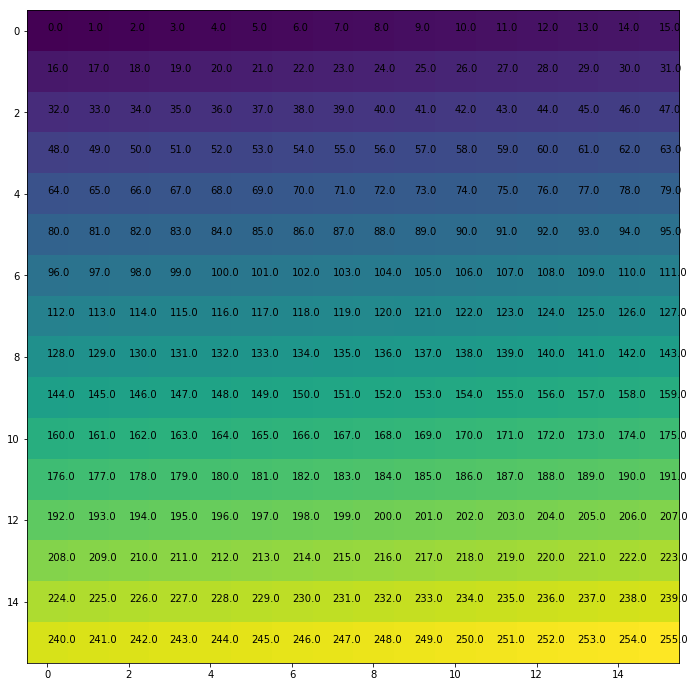

In [88]:
createCellDemo(64,4)

In [102]:
def decorateCells(ax, cellPixels, cellContent = None):
    if cellContent == "index":
        for j in range(cellPixels.shape[1]):
            for i in range(cellPixels.shape[0]):
                ax.annotate(cellPixels[i,j], (j,i))
                
    return ax, cellPixels
    

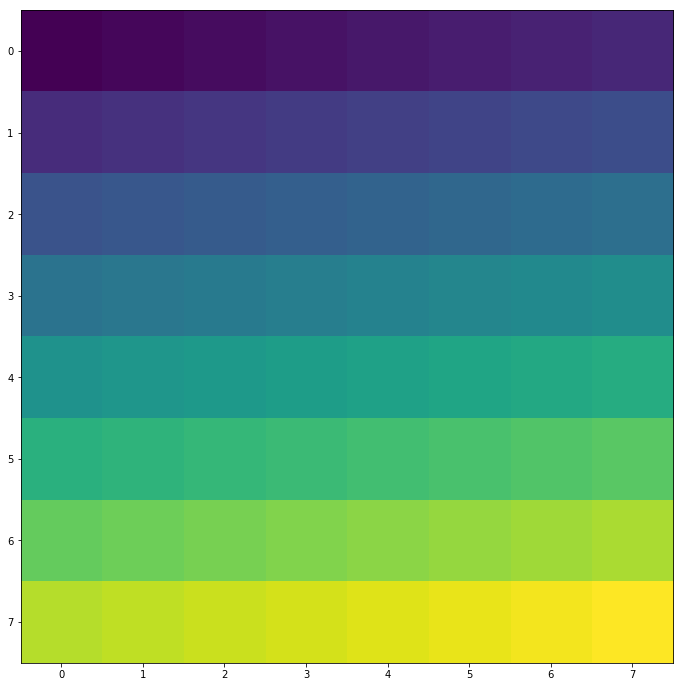

In [107]:
def createCellDemo(imageSize, cellSize, cellContent = None):
    cellImage = np.zeros((imageSize, imageSize))
    cellCount = math.floor(imageSize/cellSize)
    cellPixels = np.zeros((cellCount, cellCount)) 
    for j in range(imageSize):
        for i in range(imageSize):
            cellX = math.floor(i/cellSize)
            cellY = math.floor(j/cellSize)
            cellIndex = cellX * cellCount + cellY
            
            if cellContent == "index" or cellContent == None:
                cellPixels[cellX, cellY] = cellIndex
    
    fig, ax = plt.subplots()
    ax, cellPixels = decorateCells(ax, cellPixels, cellContent)
    ax.imshow(cellPixels)
    
createCellDemo(32,4)

In [216]:
def decorateCells(fig, ax, cellPixels, cellContent = None):
    if cellContent == "index":
        for j in range(cellPixels.shape[1]):
            for i in range(cellPixels.shape[0]):
                ax.annotate(cellPixels[i,j], (j,i))
                
    if cellContent == "orientations":
        for j in range(cellPixels.shape[1]):
            for i in range(cellPixels.shape[0]):
                ax.plot([j-math.cos(cellPixels[i,j])/4,j+math.cos(cellPixels[i,j])/4],[i+math.sin(cellPixels[i,j])/4,i-math.sin(cellPixels[i,j])/4])
                ax.annotate('{:1.2f}'.format(cellPixels[i,j]), (j-1/3,i-1/3))
                cellPixels[i,j] = 0;

    return fig, ax, cellPixels

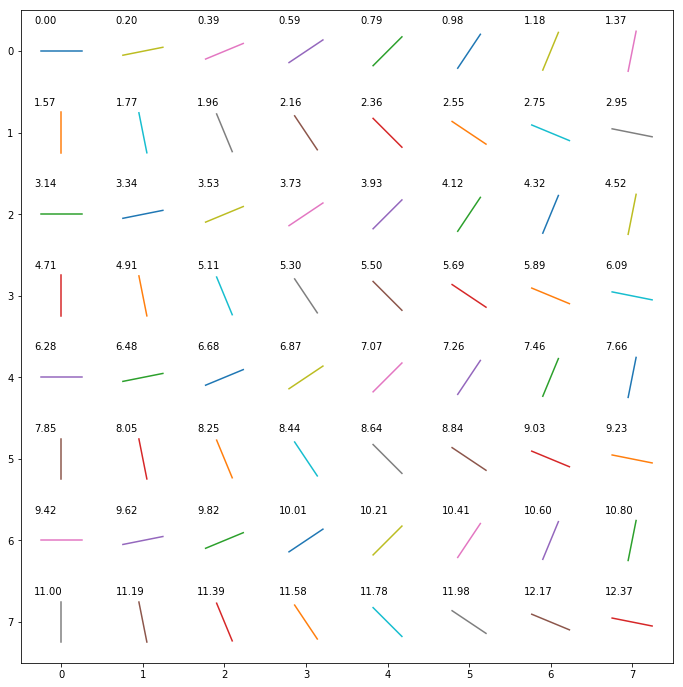

In [218]:
def createCellDemo(imageSize, cellSize, cellContent = None):
    cellImage = np.zeros((imageSize, imageSize))
    cellCount = math.floor(imageSize/cellSize)
    cellPixels = np.zeros((cellCount, cellCount)) 
    for j in range(imageSize):
        for i in range(imageSize):
            cellX = math.floor(i/cellSize)
            cellY = math.floor(j/cellSize)
            cellIndex = cellX * cellCount + cellY
            
            if cellContent == "index" or cellContent == None:
                cellPixels[cellX, cellY] = cellIndex
            elif cellContent == "orientations":
                cellPixels[cellX, cellY] = math.pi*cellIndex/cellCount/2
                
    fig, ax = plt.subplots()
    fig, ax, cellPixels = decorateCells(fig, ax, cellPixels, cellContent)
    ax.imshow(cellPixels, cmap="binary")
    
createCellDemo(32,4, "orientations")

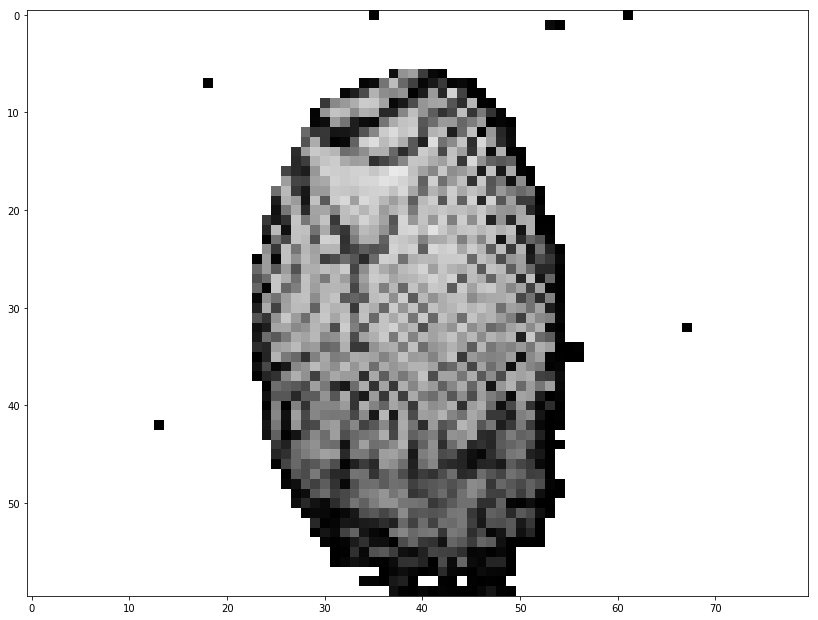

In [66]:
def imageOrientation(image, cellSize):
    rows, cols = image.shape
    cellRows = math.floor(rows/cellSize)
    cellCols = math.floor(cols/cellSize)
    cellCount = cellRows*cellCols
    cellPixels = np.zeros((cellRows, cellCols)) 
    
    for j in range(cols):
        for i in range(rows):
            cellX = math.floor(i/cellSize)
            cellY = math.floor(j/cellSize)
            cellIndex = image[i,j]
            if(cellIndex<255):
                cellPixels[cellX, cellY] = cellIndex
            
    fig, ax = plt.subplots()
               
    ax.imshow(cellPixels, cmap="binary")

image = io.imread("./DB1_B/101_2.tif")
imageOrientation(image, 8)            

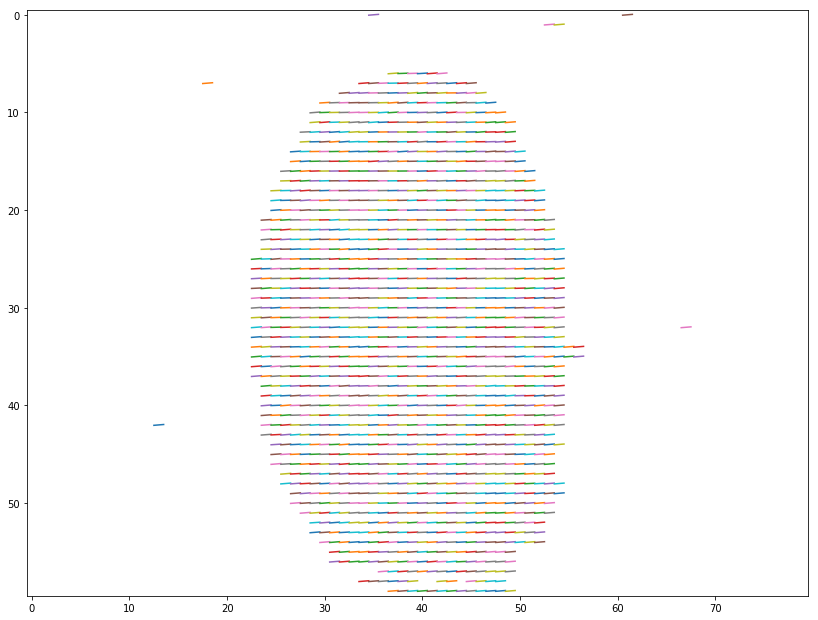

In [68]:
def imageOrientation(image, cellSize):
    rows, cols = image.shape
    cellRows = math.floor(rows/cellSize)
    cellCols = math.floor(cols/cellSize)
    cellCount = cellRows*cellCols
    cellPixels = np.zeros((cellRows, cellCols)) 
    
    for j in range(cols):
        for i in range(rows):
            cellX = math.floor(i/cellSize)
            cellY = math.floor(j/cellSize)
            cellIndex = image[i,j]
            if(cellIndex<255):
                cellPixels[cellX, cellY] = math.pi*cellIndex/cellCount/2
            
    fig, ax = plt.subplots()
    for j in range(cellCols):
        for i in range(cellRows):
            if(cellPixels[i,j]>0):
                ax.plot([j-math.cos(cellPixels[i,j])/2,j+math.cos(cellPixels[i,j])/2],[i+math.sin(cellPixels[i,j])/2,i-math.sin(cellPixels[i,j])/2])
            cellPixels[i,j] = 0;
                
    ax.imshow(cellPixels, cmap="binary")

image = io.imread("./DB1_B/101_2.tif")
imageOrientation(image, 8)    

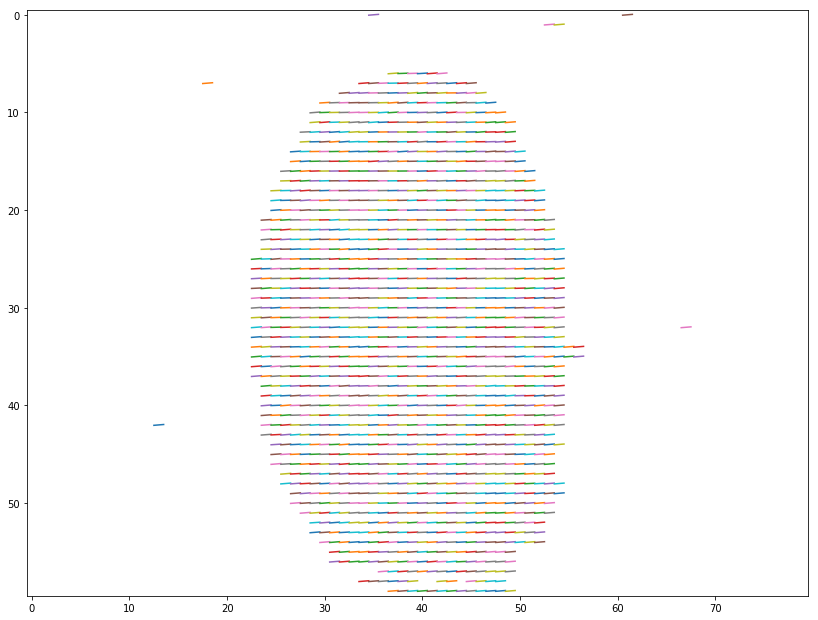

In [64]:
def imageOrientation(image, cellSize):
    rows, cols = image.shape
    cellRows = math.floor(rows/cellSize)
    cellCols = math.floor(cols/cellSize)
    cellCount = cellRows*cellCols
    cellPixels = np.zeros((cellRows, cellCols)) 
    
    for j in range(cols):
        for i in range(rows):
            cellX = math.floor(i/cellSize)
            cellY = math.floor(j/cellSize)
            cellIndex = image[i,j]
            if(cellIndex<255):
                cellPixels[cellX, cellY] = math.pi*cellIndex/cellCount/2
            
    fig, ax = plt.subplots()
    for j in range(cellCols):
        for i in range(cellRows):
            if(cellPixels[i,j]>0):
                ax.plot([j-math.cos(cellPixels[i,j])/2,j+math.cos(cellPixels[i,j])/2],[i+math.sin(cellPixels[i,j])/2,i-math.sin(cellPixels[i,j])/2])
            cellPixels[i,j] = 0;
                
    ax.imshow(cellPixels, cmap="binary")

image = io.imread("./DB1_B/101_2.tif")
imageOrientation(image, 8)  

In [54]:
def imageOrientation(image, cellSize):
    rows, cols = image.shape
    outputX = math.floor(rows/cellSize)
    outputY = math.floor(cols/cellSize)
    
    #cellCount = math.floor(max(rows, cols) / cellSize)

    sobelH = filters.sobel_h(image)
    sobelV = filters.sobel_v(image)
    
    cellPixels = np.zeros((outputX, outputY)) 
    m_sines = np.zeros((outputX, outputY)) 
    m_cosines = np.zeros((outputX, outputY)) 
    
    for j in range(cols):
        for i in range(rows):
            cellX = math.floor(i/cellSize)
            cellY = math.floor(j/cellSize)
            gx = sobelH[i,j]
            gy = sobelV[i,j]
            alfa = math.atan2(gy, gx)
            mag = math.sqrt(gx*gx+gy*gy)
            m_sines = m_sines + 2 * math.cos(alfa) * math.sin(alfa) * mag
            m_cosines = m_cosines + (math.cos(alfa) * math.cos(alfa) - math.sin(alfa) * math.sin(alfa)) * mag
            cellIndex = math.atan2(m_sines[cellY, cellX], m_cosines[cellY, cellX])
            cellPixels[cellY, cellX] = cellIndex
            
    fig, ax = plt.subplots()
    for j in range(cols):
        for i in range(rows):
            if(cellPixels[i,j]>0):
                ax.plot([j-math.cos(cellPixels[i,j])/2,j+math.cos(cellPixels[i,j])/2],[i-math.sin(cellPixels[i,j])/2,i+math.sin(cellPixels[i,j])/2], color="black")
            cellPixels[i,j] = 0;
                
    ax.imshow(cellPixels, cmap="binary")

image = io.imread("./DB1_B/101_2.tif")
imageOrientation(image, 32)    

IndexError: index 15 is out of bounds for axis 0 with size 15